# Graph-Phased Szegedy Quantum Walk

In this notebook we will show how to use SQUWALS [[1]](https://arxiv.org/abs/2307.14314), our simulator of Szegedy's quantum walks, to simulate the graph-phased Szegedy's quantum walk [[2]](https://arxiv.org/abs/2410.22011).

**It is recommended to see first the SQUWALS tutorial notebook.**

## Table of Contents

- [Packages](#0)
- [1 - Graph-Phased Szegedy Quantum Walk](#1)
- [2 - Double-coin quantum walk](#2)
- [3 - Quantum search with marked nodes by arbitrary phase rotations](#3)
- [4 - Conclusions](#4)
- [5 - References](#5)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator.

In [1]:
import numpy as np
import squwals as sw
import matplotlib.pyplot as plt
import networkx as nx

<a name='1'></a>
## 1 - Graph-Phased Szegedy quantum walk

For this walk, we need a transition matrix $G$, a matrix $\varphi$ with the link phases, and a vector $\vec{\theta}$ with the Arbitrary Phase Rotation (APR) phases [[2]](https://arxiv.org/abs/2410.22011).

Let us define the following states:

$$\left|\psi_i(\varphi)\right> := \sum_{k=0}^{N-1} e^{i\varphi_{ik}} \sqrt{G_{ki}}\left|i\right>_1\left|k\right>_2.$$

**Note: By this convention, for the edge $\left|i\right>_1\left|j\right>_2$ the associated link phase is $\varphi_{ij}$, but the transition probability is $G_{ji}$, since $G$ is defined as a column-stochastic matrix.**

The graph-phased Szegedy's quantum walk operator $U(\vec{\theta},\varphi)$ is defined as

\begin{equation}\label{U}
	U(\vec{\theta},\varphi) := SR(\vec{\theta},\varphi),
\end{equation}

where $R(\vec{\theta},\varphi)$ is a phase rotation operator around the subspace generated by the $\left|\psi_i(\varphi)\right>$ states,

\begin{equation}\label{reflection}
R(\vec{\theta},\varphi) = 2\Sigma(\vec{\theta},\varphi) - \mathbb{1}, \ \ \ \ \ \ \Sigma(\vec{\theta},\varphi) := \frac{1}{2}\sum_{i=0}^{N-1} (1-e^{i\theta_i})\left|\psi_i(\varphi)\right>\left<\psi_i(\varphi)\right|,
\end{equation}

and $S$ is the swap operator between the two quantum registers, i.e.,

\begin{equation}\label{swap}
	S := \sum_{i,j=0}^{N-1} \left|i,j\right>\left<j,i\right|.
\end{equation}

The double Szegedy operator is $W(\vec{\theta}_1,\varphi_1,\vec{\theta}_2,\varphi_2) = SR(\vec{\theta}_2,\varphi_2)SR(\vec{\theta}_1,\varphi_1)$.

<a name='2'></a>
## 2 - Double-coin quantum walk

In this section we show how to simulate the quantum walk with two coins on the infinite 1D line that appears in [[2]](https://arxiv.org/abs/2410.22011).

In order to simulate the walk on the infinite line, we need to simulate the walk in a cycle graph with a big number of nodes. For walk steps smaller than half the size of the cycle, both walks are equivalent.

We take a cycle with $N = 201$ nodes, so that the equivalent line ranges from $-100$ to $100$.

In [2]:
N = 201

The initial state of the system is $\left|\psi_0\right>$, where the states
$$\left|\psi_i\right> = \sum_{k=0}^{N-1} \sqrt{G_{ki}}\left|i\right>_1\left|k\right>_2$$
are created with the naive transition matrix $G$ and no phases. This transition matrix is obtained normalizing the adjacency matrix of the cycle, yielding a probability of $0.5$ for jumping to right or left.

Since we are simulating the walk on a cycle, we set the middle node of the graph as node 0. Note that since we have an odd number of nodes, the middle node is even, and thus it is valid as node 0.

In [3]:
# Create the naive transition matrix G.
graph = nx.cycle_graph(N)
G = nx.to_numpy_array(graph)
G = G/sum(G)

# Take the index for node 0.
initial_index = N//2

# Create the initial state.
initial_state = sw.create_psi_states(G,nodes=[initial_index])[:,0]

initial_index

100

In order to create the matrices needed to simulate the double-coin quantum walk, we need the matrix associated to each of the coined quantum walks separately.

The first coin is the Hadamard coin $H$:

$$H = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}
	1 & 1 \\
	1 & -1
\end{array}\right).$$

Its matrices are:

$$\left(G_H\right)_{ji} = h_R^2\delta_{j-1,i} + h_L^2\delta_{j+1,i},$$

$$\left(\varphi_{H}\right)_{ij} = 0,$$

$$\left(\theta_H\right)_i = \pi,$$

where

\begin{equation}
h_R = \frac{1}{\sqrt{4-2\sqrt{2}}}, \ \ \ \ \ h_L = \frac{\sqrt{2}-1}{\sqrt{4-2\sqrt{2}}}.
\end{equation}

In [4]:
# Create the transition matrix.
hr = 1/np.sqrt(4-2*np.sqrt(2))
hl = (np.sqrt(2)-1)/np.sqrt(4-2*np.sqrt(2))
prob_right = hr**2
prob_left = hl**2

G_hadamard_coin = np.zeros([N,N])
G_hadamard_coin[-1,0] = prob_left
for index in range(1,N):
    G_hadamard_coin[index-1,index] = prob_left
G_hadamard_coin[0,-1] = prob_right
for index in range(0,N-1):
    G_hadamard_coin[index+1,index] = prob_right

# Create the matrix with the link phases.
phi_hadamard_coin = np.zeros([N,N])

# Set the APR phase.
theta_hadamard_coin = np.pi

The other coin is $\widetilde{N}$:

$$\widetilde{N} = -\frac{1+\text{i}}{2} 
	\left(\begin{array}{cc}
		1 & 1 \\
		-1 & 1
	\end{array}\right).$$

Its matrices are:

$$\left(G_{\widetilde{N}}\right)_{ji} = \frac{1}{2}\delta_{j-1,i} + \frac{1}{2}\delta_{j+1,i},$$

$$\left(\varphi_{\widetilde{N}}\right)_{ij} = \frac{\pi}{2}\delta_{i,j+1},$$

$$\left(\theta_\widetilde{N}\right)_i = \frac{\pi}{2}.$$

In [5]:
# Create the transition matrix.
prob_left = 0.5
prob_right = 1 - prob_left

G_other_coin = np.zeros([N,N])
G_other_coin[-1,0] = prob_left
for index in range(1,N):
    G_other_coin[index-1,index] = prob_left
G_other_coin[0,-1] = prob_right
for index in range(0,N-1):
    G_other_coin[index+1,index] = prob_right

# Create the matrix with the link phases.
phi_other_coin = np.zeros([N,N])
phi_other_coin[0,-1] = np.pi/2
for index in range(1,N):
    phi_other_coin[index,index-1] = np.pi/2

# Set the APR phase.
theta_other_coin = np.pi/2

For the double-coin quantum walk, we use the $H$ coin for even nodes, and the $\widetilde{N}$ coin for odd nodes. Thus, the matrices are:

$$G_{ji} = \left\lbrace\begin{array}{c}
	h_R^2\delta_{j-1,i} + h_L^2\delta_{j+1,i} \ \ \ \text{if} \ i \ \text{is even},\\
	\\
	\displaystyle \frac{1}{2}\delta_{j-1,i} + \frac{1}{2}\delta_{j+1,i} \ \ \ \ \ \text{if} \ i \ \text{is odd},
\end{array}
\right.
$$

$$\varphi_{ij} = \left\lbrace\begin{array}{c}
	\ \ \ \ \ \ \ 0 \ \ \ \ \ \ \ \text{if} \ i \ \text{is even},\\
	\\
	\displaystyle \frac{\pi}{2}\delta_{i,j+1} \ \ \ \text{if} \ i \ \text{is odd},
	\end{array}
	\right.
$$

$$\theta_i = \left\lbrace\begin{array}{c}
	\displaystyle \ \ \pi \ \ \ \ \text{if} \ i \ \text{is even},\\
	\\
	\displaystyle \frac{\pi}{2} \ \ \ \text{if} \ i \ \text{is odd}.
\end{array}
\right.
$$

Note that for the transition matrices we take the columns for the parity of the node, whereas for the link phases we take the rows.

In [6]:
G_double_coin = np.zeros([N,N])
phi_double_coin = np.zeros([N,N])
theta_double_coin = np.zeros([N])

for node in range(N):
    if node%2 == 0:  # Node is even.
        G_double_coin[:,node] = G_hadamard_coin[:,node]  # Take the column for the transition matrix.
        phi_double_coin[node,:] = phi_hadamard_coin[node,:]  # Take the row for the link phases.
        theta_double_coin[node] = theta_hadamard_coin
    if node%2 == 1:  # Node is odd.
        G_double_coin[:,node] = G_other_coin[:,node]  # Take the column for the transition matrix.
        phi_double_coin[node,:] = phi_other_coin[node,:]  # Take the row for the link phases.
        theta_double_coin[node] = theta_other_coin

We create the operators $R(\vec{\theta},\varphi)$ for each of the three different quantum walks, and create the unitary evolution operators $U(\vec{\theta},\varphi)$.

In [7]:
# Create the operator R for the three quantum walks.
R_hadamard_coin = sw.Reflection(G_hadamard_coin,extended_phases=phi_hadamard_coin,apr_phase=theta_hadamard_coin)
R_other_coin = sw.Reflection(G_other_coin,extended_phases=phi_other_coin,apr_phase=theta_other_coin)
R_double_coin = sw.Reflection(G_double_coin,extended_phases=phi_double_coin,apr_phase=theta_double_coin)

# Create the operator S.
S = sw.Swap()

# Create the evolution operators U for the three quantum walks.
U_hadamard_coin = S * R_hadamard_coin
U_other_coin = S * R_other_coin
U_double_coin = S * R_double_coin

We simulate the evolution for 100 time steps for the three quantum walks.

In [8]:
# We take the distribution at the last time step.
probability_distribution_hadamard_coin = sw.quantum_szegedy_simulator(U_hadamard_coin, initial_state, time_steps=100, measure=1)[-1]
probability_distribution_other_coin = sw.quantum_szegedy_simulator(U_other_coin, initial_state, time_steps=100, measure=1)[-1]
probability_distribution_double_coin = sw.quantum_szegedy_simulator(U_double_coin, initial_state, time_steps=100, measure=1)[-1]

Finally, we plot the probability distributions.

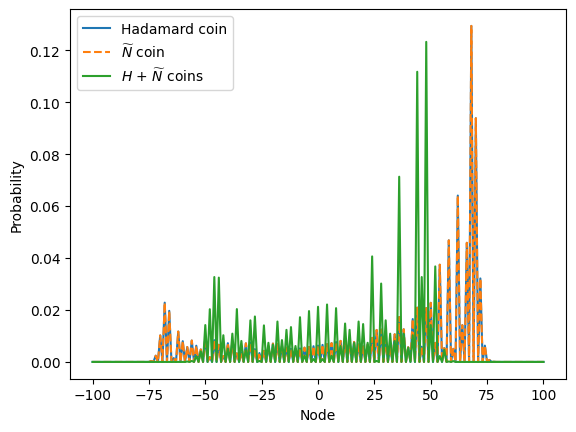

In [9]:
nodes = np.arange(-N//2+1,N//2+1)  # Create a vector with nodes indexes from -100 to 100.

plt.plot(nodes,probability_distribution_hadamard_coin)
plt.plot(nodes,probability_distribution_other_coin,'--')
plt.plot(nodes,probability_distribution_double_coin)
plt.xlabel('Node')
plt.ylabel('Probability')
plt.legend(['Hadamard coin','$\widetilde{N}$ coin','$H$ + $\widetilde{N}$ coins'])
plt.show()

<a name='3'></a>
## 3 - Quantum search with marked nodes by arbitrary phase rotations

We can use multiple arbitrary phase rotations in order to mark nodes in a graph for a search problem [[2]](https://arxiv.org/abs/2410.22011), so that it is equivalent to marking with absorbing vertices [[3]](https://link.springer.com/article/10.1007/s11128-016-1427-4).

In this case we have a complete graph with 1000 nodes. The graph is fully connected without loops, so that the diagonal elements of the transition matrix are $0$ and the non-diagonal elements are $1/(N-1)$.

In [10]:
# Create the transition matrix.
N = 1000
G = np.ones([N,N])*(1/(N-1))
# Delete the diagonal elements.
for k in range(N):
    G[k,k] = 0

In order to mark nodes with absorbing vertices for the search problem, the directed edges pointing from them are removed, and a self-loop is added. Thus, the column of each of these nodes is deleted, and the diagonal element is changed by $1$. Let's call $G'$ to the new matrix. In this case, $M = 2$ nodes are marked. Since all nodes are equal, it does not matter what nodes are being marked. Thus, we mark the first $M$ nodes.

In [11]:
M = 2
marked_nodes = np.arange(M)
G_prime = G.copy()
for node in marked_nodes:
    G_prime[:,node] = 0
    G_prime[node,node] = 1

np.allclose(np.sum(G_prime,axis=0),np.ones([N]))  # Check that all the elements of each column add up to 1.

True

The unitary operator is

$$W_{G'} = R'_BR'_A$$

according to the original formulation of Szegedy's quantum walk. In the notation of our simulator [[1]](https://arxiv.org/abs/2307.14314) we have $R_A = R$ and $R_B = SRS$, thus, $W_{G'} = SR'SR'$.

The reflection operator $R'$ is created using $G'$.

In [12]:
R_prime = sw.Reflection(G_prime,name='G\'')
S = sw.Swap()
W_G_prime = sw.Unitary([R_prime,S,R_prime,S],name='prime')
print(W_G_prime)
W_G_prime.info()

SRSR
Custom unitary: prime
 1 - Reflection G'
 2 - Swap
 3 - Reflection G'
 4 - Swap


The initial state is the one created with the original matrix $G$.

In [13]:
initial_state = sw.create_initial_state(G)

The quantum walk is performed during 100 steps and the first register is measured.

In [14]:
evolution_prime = sw.quantum_szegedy_simulator(W_G_prime,initial_state,time_steps=100,measure=1)

The probability of measuring a marked node is obtained summing the probability of the first $M$ nodes.

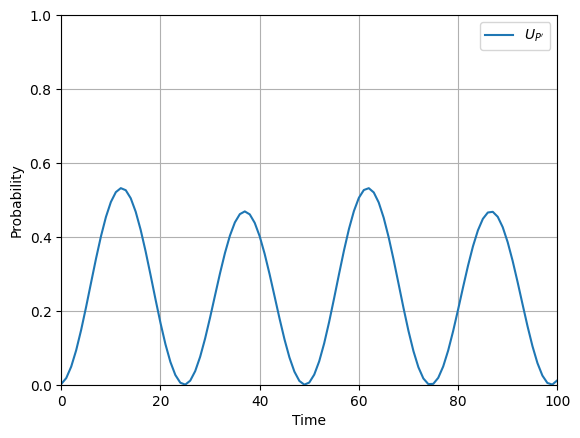

In [15]:
probability_prime = np.sum(evolution_prime[:,marked_nodes],axis=-1)

plt.plot(probability_prime,label='$U_{P\'}$')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.xlim([0,100])
plt.ylim([0,1])
plt.grid()
plt.show()

Now we show the search algorithm marking with arbitrary phase rotations [[2]](https://arxiv.org/abs/2410.22011). In this case, the transition matrix is the original matrix $G$ of the complete graph, and the quantum walk operator is defined as:

$$W_{G}(\vec{\theta}) = SR(\vec{\theta})SR(\vec{\theta}).$$

For non-marked nodes, the phase $\theta_i = \pi$, which is the default phase of Szegedy's quantum walk. For marked nodes we set $\theta_i = 0$.

In [16]:
theta_vector = np.array([np.pi for a in range(N)])
# Set the apr phase of the marked nodes to 0.
theta_vector[marked_nodes] = 0
theta_vector[:20]

array([0.        , 0.        , 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265])

The phase rotation operator is created using the transition matrix $G$ and the vector $\vec{\theta}$.

In [17]:
R_apr = sw.Reflection(G,name='R phase',apr_phase=theta_vector)
W_G_apr = sw.Unitary([R_apr,S,R_apr,S],name='apr')
print(W_G_apr)
# W_G_apr.info()

SRSR


The quantum walk is performed during 100 steps and the first register is measured. The initial state is the same.

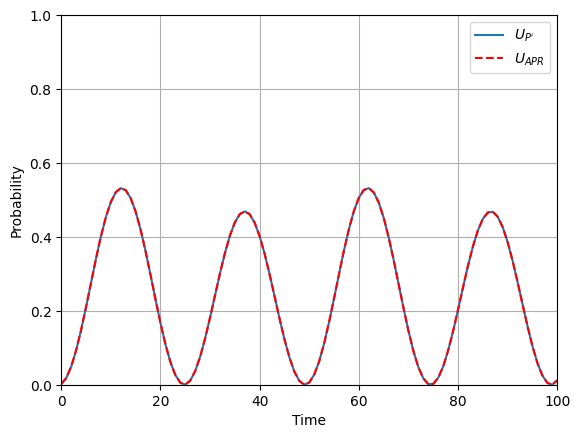

In [18]:
evolution_apr = sw.quantum_szegedy_simulator(W_G_apr,initial_state,time_steps=100,measure=1)

probability_apr = np.sum(evolution_apr[:,marked_nodes],axis=-1)

plt.plot(probability_prime,label='$U_{P\'}$')
plt.plot(probability_apr,label='$U_{APR}$',color='r',linestyle='--')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.xlim([0,100])
plt.ylim([0,1])
plt.grid()
plt.show()

As we can see, the curve for the vertex-phased walk overlaps with the one using absorbing vertices.

<a name='4'></a>
## 4 - Conclusions

We have seen how to simulate the graph-phased Szegedy's quantum walk using SQUWALS.

We have simulated two examples. A multi-coined quantum walk that can be cast into Szegedy's quantum walk, and a quantum search problem marking nodes with arbitrary phase rotations.

<a name='5'></a>
## 5 - References

- [1] **[S. A. Ortega and M. A. Martin-Delgado. SQUWALS: A Szegedy QUantum WALks Simulator. arXiv:2307.14314.](https://arxiv.org/abs/2307.14314)**
- [2] **[S. A. Ortega and M. A. Martin-Delgado. Complex-Phase Extensions of Szegedy Quantum Walk on Graphs. arXiv:2307.14314.](https://arxiv.org/abs/2410.22011)**
- [3] **[R. A. Santos. Szegedy’s quantum walk with queries. Quantum Information Processing, 15:4461–4475, 2016.](https://link.springer.com/article/10.1007/s11128-016-1427-4)**